In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [2]:
plt.rcParams['lines.linewidth'] = 0.1

import umap

from ceciestunepipe.util.dimension import umapred as dim
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import data as dt


In [3]:
reload(et)
sess_par = {'bird': 's_b1238_22',
           'sess': '2022-01-27',
           'probe': 'probe_0',
           'sort': 'sort_0'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

sess_epochs = et.list_sgl_epochs(sess_par)


### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

2022-02-08 14:40:14,737 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx', 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-06-14', 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/2', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/2'}, 'files': {'par': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/2/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.json', 'kwd': '/scratch/earneodo/s_b125

In [5]:
bout_df_path = os.path.join(exp_struct['folders']['derived'], 'bout_df.pkl')
#umap_bout_df_path = os.path.join(exp_struct['folders']['derived'], 'bout_df_umap.pkl')

# bout_df.to_pickle(bout_df_path)
# logger.info('saved bout_df to {}'.format(bout_df_path))

bout_df = pd.read_pickle(bout_df_path)
logger.info('loaded bout_df from {}'.format(bout_df_path))

#todo: make a better bout_id
bout_df['bout_id'] = bout_df['start_sample_nidq']

2021-09-14 15:50:04,034 root         INFO     loaded bout_df from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/bout_df.pkl


In [6]:
bout_df.head()

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,sxx_all,sxx,fr_arr,bout_id
0,313397,470105,37010,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-1308, -1299, -1293, -1277, -1277, -1299, -12...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.006666666666666667, 0.0, 0.0, 0....",313397
1,1296784,1945211,29739,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-513, -493, -491, -505, -516, -502, -510, -50...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1296784
2,2220373,3330616,35610,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2185, 2147, 2129, 2122, 2154, 2135, 2138, 213...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2220373
3,3589156,5383825,37030,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[331, 327, 327, 343, 361, 351, 361, 363, 346, ...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3589156
4,5673330,8510137,29449,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-42, -42, -9, -8, -4, 0, -35, 3, 8, -17, -12,...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5673330


In [40]:
pd.__version__

'1.3.2'

In [29]:
bout_df.iloc[1]['spk_arr'].shape

(45, 1170003)

In [33]:
bout_df.iloc[1]['sxx_all']

(array([ 312.4957681 ,  351.55773912,  390.61971013,  429.68168114,
         468.74365215,  507.80562317,  546.86759418,  585.92956519,
         624.99153621,  664.05350722,  703.11547823,  742.17744924,
         781.23942026,  820.30139127,  859.36336228,  898.4253333 ,
         937.48730431,  976.54927532, 1015.61124633, 1054.67321735,
        1093.73518836, 1132.79715937, 1171.85913038, 1210.9211014 ,
        1249.98307241, 1289.04504342, 1328.10701444, 1367.16898545,
        1406.23095646, 1445.29292747, 1484.35489849, 1523.4168695 ,
        1562.47884051, 1601.54081153, 1640.60278254, 1679.66475355,
        1718.72672456, 1757.78869558, 1796.85066659, 1835.9126376 ,
        1874.97460862, 1914.03657963, 1953.09855064, 1992.16052165,
        2031.22249267, 2070.28446368, 2109.34643469, 2148.40840571,
        2187.47037672, 2226.53234773, 2265.59431874, 2304.65628976,
        2343.71826077, 2382.78023178, 2421.8422028 , 2460.90417381,
        2499.96614482, 2539.02811583, 2578.09008

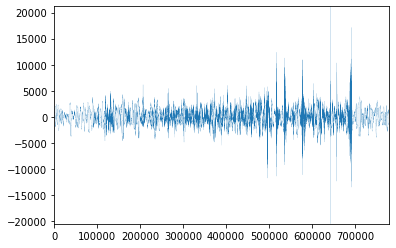

In [31]:
plt.plot(bout_df.iloc[1]['mic_arr'])

In [32]:
1170003/779988

1.5000269234911305

In [27]:
bout_df.iloc[1]

start_sample_nidq                                              1296784
start_sample_ap_0                                              1945211
len_ms                                                           29739
spk_arr              [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
mic_arr              [-513, -493, -491, -505, -516, -502, -510, -50...
sxx_all              ([312.49576810265256, 351.55773911548414, 390....
sxx                  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
fr_arr               [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
bout_id                                                        1296784
Name: 1, dtype: object

### Show a bout spectrogram and the raster across all units

In [37]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax

def show_bout(bout_df, bout_id, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(16, 32))
        gs = fig.add_gridspec(6, 1)
        ax = []
        ax.append(fig.add_subplot(gs[0, :]))
        ax.append(fig.add_subplot(gs[1, :]))
        ax.append(fig.add_subplot(gs[2:, :]))
        
    the_bout = bout_df.loc[bout_df['bout_id']==bout_id]

    sx = the_bout['sxx'].values[0]
    
    ax[0].plot(the_bout['mic_arr'].values[0])
    
    ax[1].imshow(np.log(the_bout['sxx'].values[0][::-1]), aspect='auto', cmap='inferno');
    
    plot_as_raster(the_bout['spk_arr'].values[0], ax=ax[2])
    #ax[2].imshow((the_bout['fr_arr'].values[0][::-1]), aspect='auto', cmap='inferno');
                           
    return ax

In [38]:
bout_id_list = bout_df['bout_id']

In [41]:
bout_id_list

0        313397
1       1296784
2       2220373
3       3589156
4       5673330
5       7391508
6       8248897
7       9263085
8      26541669
9      27517657
10     28458045
11     29537631
12     30242222
13     31715004
14     32499594
15     38182323
16     39407508
17     40385696
18     53071337
19     55349309
20     60202848
21     62608618
22     64277197
23     65489182
24     66619168
25     67675755
26     68941139
27     76993038
28     77566831
29     78392421
30     79476807
31     80566593
32     82718967
33     84542544
34     86428920
35     99878152
36    102204523
37    105274685
38    108787041
39    111205610
40    128217398
41    134368321
42    135431708
43    326611918
44    327705904
45    340144549
46    344735691
47    347761653
Name: bout_id, dtype: int64

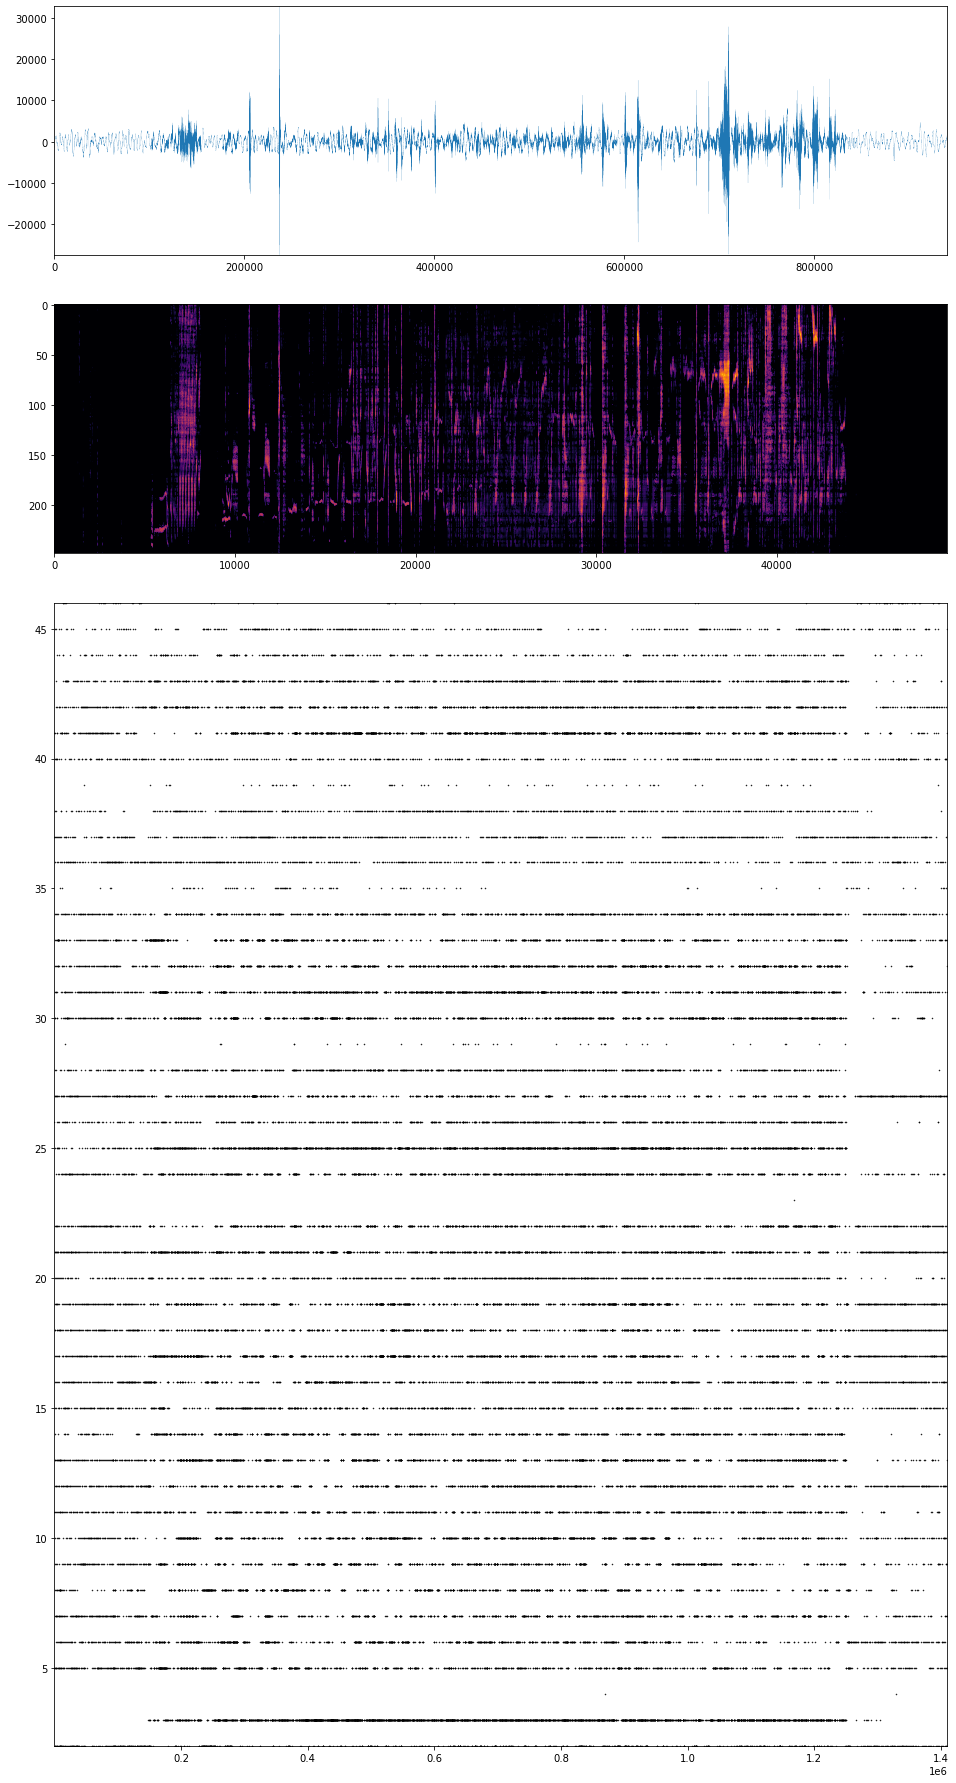

In [39]:
show_bout(bout_df, bout_id_list[0])

#### show spectrograms

In [ ]:
#show_bout = range(n_show)

show_bout = [1, 5, 13, 27]
n_show = len(show_bout) 
fig, ax = plt.subplots(nrows=n_show, figsize=(16, 4*n_show), sharex=True)

for i_ax, i_bout in enumerate(show_bout):
    ax[i_ax].imshow(np.log(bout_df.iloc[i_bout]['sxx'][::-1]), aspect='auto', cmap='inferno')
    ax[i_ax].set_title('i_bout {}'.format(i_bout))

In [ ]:
umap_win = 50
i_bout = 1

fr = bout_df.iloc[i_bout]['fr_arr']
reducer_fr, emb_fr, frflat = dim.rolling_umap(fr, umap_win, parametric=False, random_state=42)

sx = bout_df.iloc[i_bout]['sxx']
reducer, emb, rxflat = dim.rolling_umap(sx, umap_win, parametric=False, random_state=42)

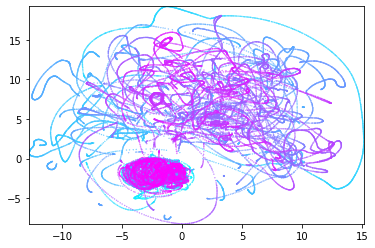

In [9]:
plt.scatter(*emb.T, c=np.arange(emb.shape[0]), s=0.1, cmap='coolwarm');

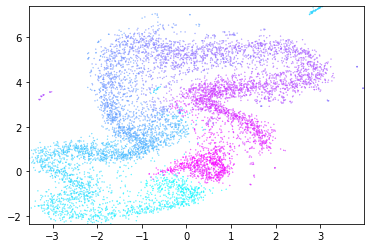

In [10]:
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='coolwarm');

In [11]:
i_bout = 5

fr = bout_df.iloc[i_bout]['fr_arr']
reducer_fr, emb_fr, frflat = dim.rolling_umap(fr, umap_win, parametric=False, random_state=42)

sx = bout_df.iloc[i_bout]['sxx']
reducer, emb, rxflat = dim.rolling_umap(sx, umap_win, parametric=False, random_state=42)

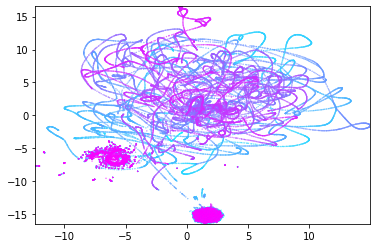

In [12]:
plt.scatter(*emb.T, c=np.arange(emb.shape[0]), s=0.1, cmap='cool');

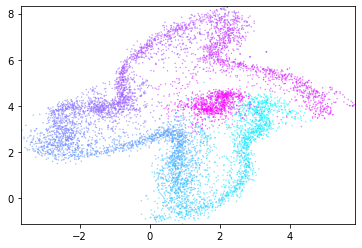

In [13]:
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
plt.subplots(nrows=n_show, figsize=(16, 4*n_show)

In [5]:
bout_df.head(1)

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,sxx_all,sxx,fr_arr,bout_id
0,313397,470105,37010,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[473, 447, 466, 489, 520, 563, 660, 658, 612, ...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",313397


#### make many embeddings

### pick these two particular bouts

In [6]:
bout_i_list = [1, 5, 13]
bout_id_list = [bout_df.iloc[i]['bout_id'] for i in bout_i_list]